# PyTorch Workflow

Let's explore a an example PyTorch end-to-end workflow.

Resouces:
* Ground truth notebook - https://github.com/VanLinLin/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version of notebook - https://www.learnpytorch.io/01_pytorch_workflow/

In [19]:
what_were_covering = {1: "data (prepare and load)",
                                2: "build model",
                                3: "fitting the model to data (training)",
                                4: "making prediction and evaluting a model (inference)",
                                5: "saving and loading a model",
                                6: "putting a it all together"}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making prediction and evaluting a model (inference)',
 5: 'saving and loading a model',
 6: 'putting a it all together'}

In [20]:
import torch
from torch import nn  # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.13.0+cu117'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

* Excel speadsheet
* Images of any kind
* Video (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

TO showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to nake a straight line with known **parameters**.

In [21]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[: 10], y[: 10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [22]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and set with our data.

In [23]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[: train_split], y[: train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [24]:
def plot_prediction(train_data=X_train, 
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

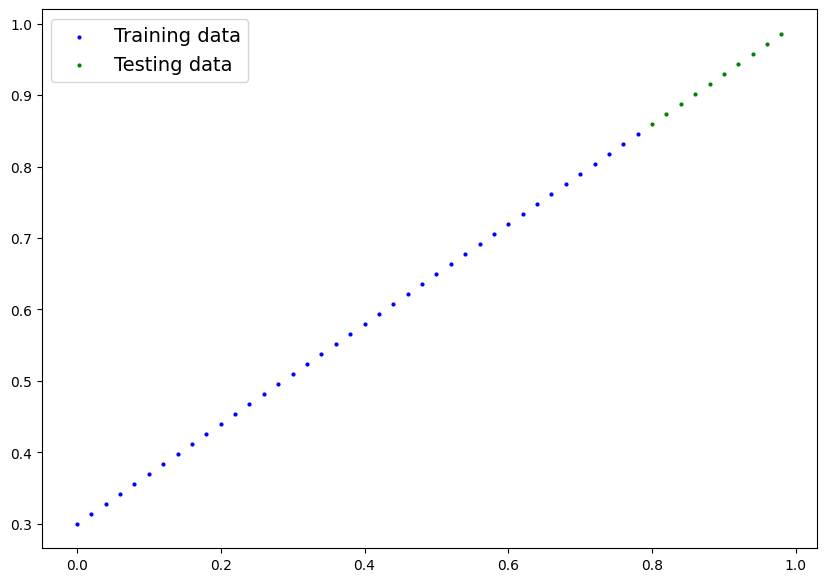

In [25]:
plot_prediction()


## 2. Build model

Our first PyTorch model!

This is very exciting... let's do it!

Because we're going to be building classes throughout the course, I'd recommend getting familiar with OOP in Python, to do so you can use the following resource from Real Python:https://realpython.com/python3-object-oriented-programming/

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?
1. Gradient descent - https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropagation - https://www.youtube.com/watch?v=Ilg3gGewQ5U

In [26]:
from torch import nn


# Create linear regression model class
class LinearRegressionModel(nn.Module):  # <- alomst everything in PyTorch inherhits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,  # <- start with random weights (this will get adjusted as the model learns)
                                                        dtype=torch.float),  # <- PyTorch loves float32 by default
                                                        requires_grad=True)  # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1,  # <- start with random bias (this will get adjusted as the model learns)
                                                    dtype=torch.float),  # <- PyTorch loves float32 by default
                                                    requires_grad=True)  # <- can we update this value with gradient descent?))

        # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:  # <- "x" is the input data
            return self.weights * x + self.bias  # this is the linear regression formula


### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subcalss it, you should overwrite forward()
* torch.optim - this whrer the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

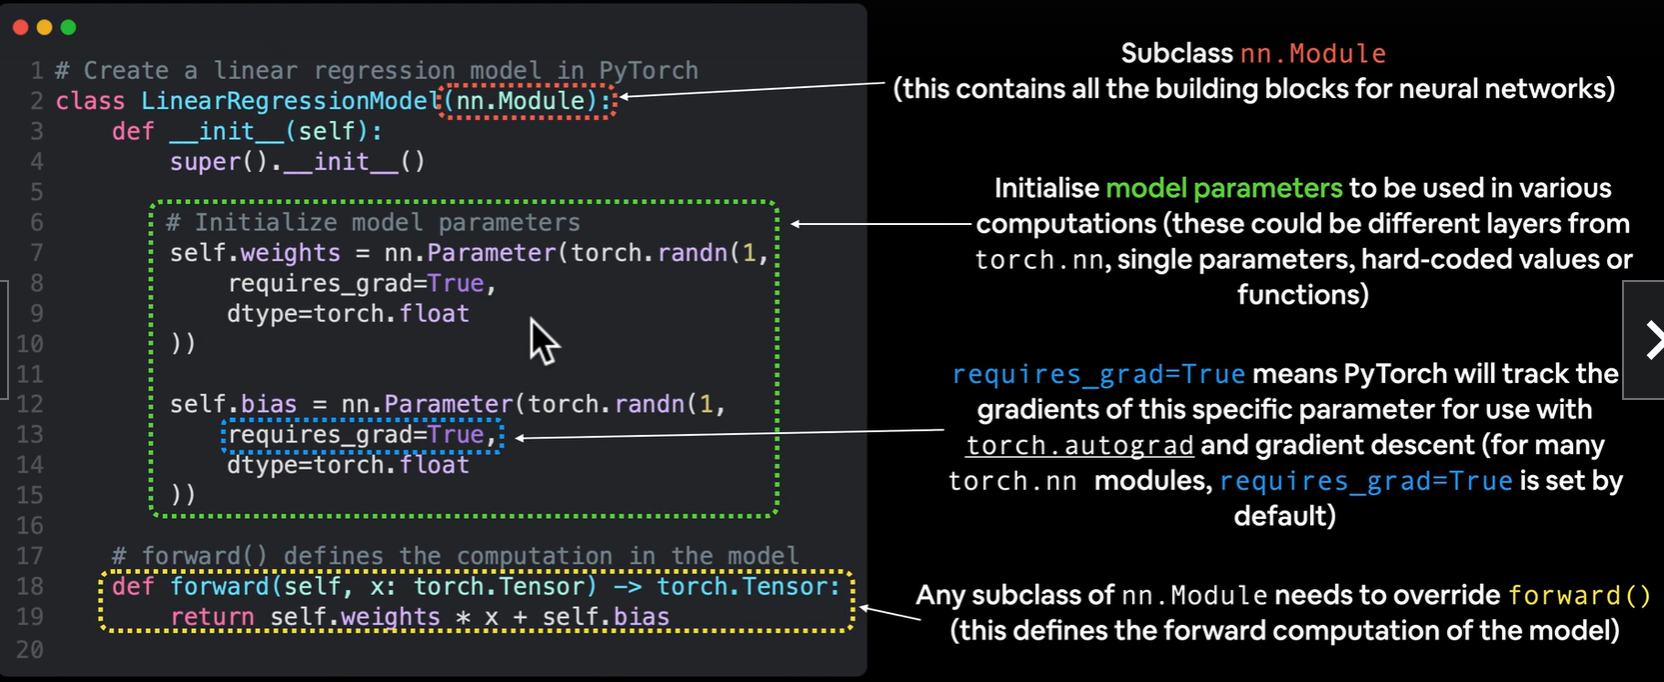

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.Parameters()`.

In [27]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [28]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predic `y_test` based on `X_test`.

When we pass data through our model, it's goiung to run it through the `forward()` method.

In [31]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# You can also do something similar with torch.no_grad(), however, torch.inference_mode() is preferred.
# with torch.no_grad():
#     y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

See more on inference mode here - https://twitter.com/PyTorch/status/1437838231505096708

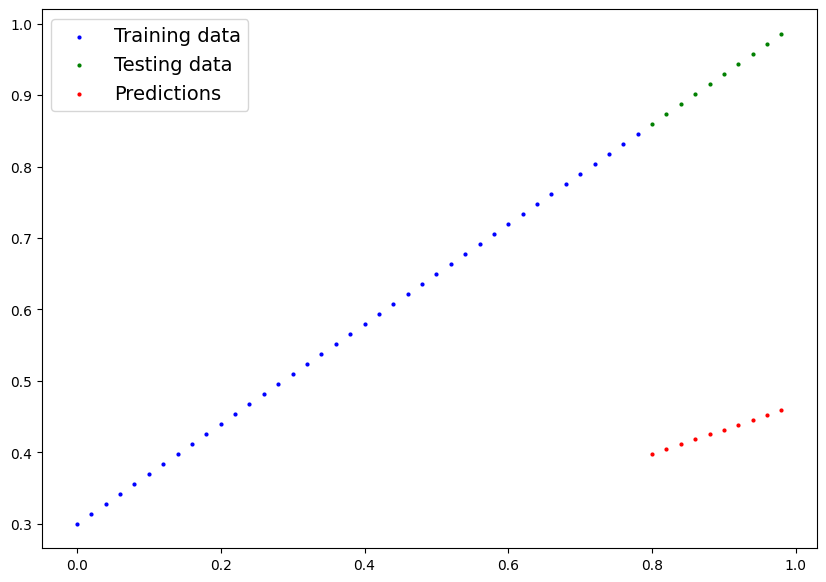

In [30]:
plot_prediction(predictions=y_preds)